# 作业三：风格迁移 —— 自由发挥
该工作是《深度学习基础》选修课程的系列作业之三。分工表可见报告。
## 任务概述
&emsp;&emsp;本次任务为**风格迁移**，结合课上所学内容以及网上搜集的资料，我们决定以**VGG**为基本模型，对**VGG**进行针对风格迁移的优化后结合**PCA**，实现最佳的风格迁移效果。

&emsp;&emsp;具体而言，我们先对背景图片和内容图片进行一些基本处理，提取出图片的主要成分以进行风格的融合与迁移；然后，我们以**VGG**模型为**baseline**，对**VGG**进行适当修改，加入了torch.nn模块中对于风格迁移的优化函数，并且加入了一些对于图片分辨率的优化，使得最终的图片融合度更好、分辨率更高。


## 基本模块和参数的确定

&emsp;&emsp;我们将一些基本库和模块的引入以及基本参数的确定放在最前端，使得整个文档的条理更清晰，方便展示函数的作用时直接调用相关参数。

&emsp;&emsp;本部分纯手工完成。

In [46]:
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as transforms
from tqdm import tqdm

from PIL import Image

# 规定随机种子，确保结果的可复现性，便于调整参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_grad_enabled(False)

# 此处给出后面需要进行风格迁移的风格和内容的url，
# 便于后面函数直接进行调用
style1="style/sundown.jpg"
content1="content/building.jpg"
style2="style/sweet.jpg"
content2="content/cat.jpg"
# 保存生成结果文件夹的url
output_dir="output/"

## 图片的处理及数据转换

&emsp;&emsp;**load_image**函数的作用是加载图片数据，先将图片数据维度全部四舍五入转化成32的倍数，然后再将数据重塑成张量形式以备处理，**save_image**函数的作用是保存最终图片到本地。

&emsp;&emsp;同时为了增强数据的可读性验证数据读入的正确性，下面的**show_image**函数实现了读取图片和展示图片以及图片label的功能。为了更规范、美观地展示图片，我们使用了matplotlib库来展示图片。

&emsp;&emsp;本部分纯手工完成。

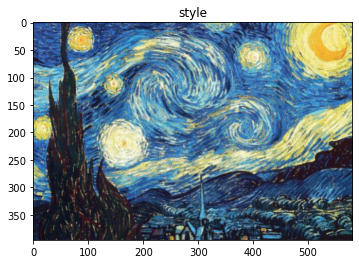

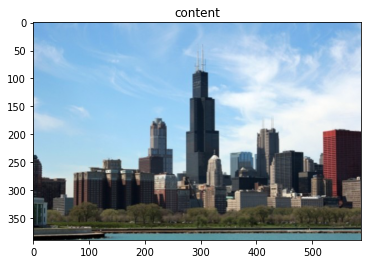

In [47]:
# 加载图片并将图片转化成张量
def load_image(filepath, size, scale=5):
    img = Image.open(filepath).convert(mode="RGB")
    size *= scale
    wpercent = size / float(img.size[0])
    hsize = int((float(img.size[1]) * float(wpercent)))
# 将图片数据维度全部四舍五入转化成32的倍数
    size = int(size + 32 - 1) & -32
    hsize = int(hsize + 32 - 1) & -32
    img = img.resize((int(size), hsize), Image.ANTIALIAS)
    return transforms.to_tensor(img).unsqueeze(0).to(device)

# 保存图片
def save_image(output, style,content,output_dir):
    outs=[style.split("/")[-1].split(".")[0],content.split("/")[-1].split(".")[0]]
    outname = "_".join(outs)
    torchvision.utils.save_image(output, f"{output_dir}/{outname}.png")
    return output_dir+outname+".png"

# 展示图片（此处使用matplotlib库进行展示）
def show_image(filepath):
    img = Image.open(filepath).convert(mode="RGB")
    plt.imshow(img)
    plt.axis('on')
    plt.title(filepath.split('/')[0])
    plt.show()

show_image(style1)
show_image(content1)

## 基于VGG的训练模型

&emsp;&emsp;根据网络上查询相关的资料对比后，我们选定了**VGG**卷积神经网络模型作为整个模型的baseline。由于**VGG19**卷积神经网络在物体识别方面有着较为突出的表现，每一层神经网络都会利用上一层的输出来进一步提取更加复杂的特征，直到复杂到能被用来识别物体为止，所以每一层都可以被看做很多个局部特征的提取器。所以我们决定采用**VGG19**为模型基础以获得最佳性能。以下是**VGG19**的总体架构图和模型图。
![](pictures/VGGstructure.PNG)
![](pictures/VGG19.PNG)

&emsp;&emsp;在我们的模型中，我们对**VGG19**中的模块做出了一些针对风格迁移特点的优化，适当加入了torch.nn模块中的**ReflectionPad2d**函数。该函数利用输入边界的反射来填充输入张量，在风格迁移中比较常用，可以使得模型获得更好的卷积效果。

&emsp;&emsp;本部分借鉴了网络上有关**VGG19**的代码后手工完成。

In [48]:
# 编码模块
encoder_block = [
    [
        nn.Conv2d(3, 3, (1, 1)),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(3, 64, (3, 3)),
        nn.ReLU(),
    ],
    # encode block 1
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 128, (3, 3)),
        nn.ReLU(),
    ],
    # encode block 2
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 256, (3, 3)),
        nn.ReLU(),
    ],
    # encode block 3
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 512, (3, 3)),
        nn.ReLU(),
    ],
    # encode block 4
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
    ],
    # encode block 5
]


class Encoder(nn.Module):
    def __init__(self, depth):
        super(Encoder, self).__init__()
        self.depth = depth
        # 决定网络的深度
        self.model = nn.Sequential(*chain.from_iterable(encoder_block[:depth]))
        # 将预训练的参数权重加载到模型之中
        self.model.load_state_dict(torch.load("/content/models/encoder_model"+str(depth)+"_1.pth"))

    def forward(self, x):
        # 对张量进行维度交换，方便后面进行主成分分析和矩阵旋转
        return self.model(x).permute(0, 2, 3, 1)

    def __exit__(self):
        del self
        torch.cuda.empty_cache()


# 解码模块
decoder_block = [
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 512, (3, 3)),
        nn.ReLU(),
    ],
    # decode block 5
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(512, 256, (3, 3)),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 256, (3, 3)),
        nn.ReLU(),
    ],
    # decode block 4
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(256, 128, (3, 3)),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 128, (3, 3)),
        nn.ReLU(),
    ],
    # decode block 3
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(128, 64, (3, 3)),
        nn.ReLU(),
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
    ],
    # decode block 2
    [
        nn.ReflectionPad2d((1, 1, 1, 1)),
        nn.Conv2d(64, 3, (3, 3)),
    ],
    # decode block 1
]


class Decoder(nn.Module):
    def __init__(self, depth):
        super(Decoder, self).__init__()
        self.depth = depth
        # 决定网络的深度
        self.model = nn.Sequential(*chain.from_iterable(decoder_block[-depth:]))
        # 将预训练的参数权重加载到模型之中
        self.model.load_state_dict(torch.load("/content/models/decoder_model"+str(depth)+"_1.pth"))

    def forward(self, x):
        # 对张量进行维度交换，方便后面进行主成分分析和矩阵旋转
        return self.model(x.permute(0, 3, 1, 2))

    def __exit__(self):
        del self
        torch.cuda.empty_cache()


## 模型训练

&emsp;&emsp;通过对style矩阵的随机变换后，计算变换后矩阵和当前style层矩阵之间的相似度，得到新的style矩阵并作为当前层的输入。

&emsp;&emsp;本部分纯手工完成。

In [49]:
def singledeal(matrix,rate=1e-3):
    mu = matrix.mean((2, 3), keepdim=True)
    hist = (matrix - mu).view(matrix.size(1), -1)
    cov = torch.matmul(hist , hist.T) / hist.shape[1] + rate * torch.eye(hist.shape[0], device=device)
    eva, eve = torch.linalg.eigh(cov,UPLO='U')
    Q = torch.matmul(torch.matmul(eve, torch.sqrt(torch.diag(eva))), eve.T)
    return Q, mu, hist

# 计算矩阵的相似度
def calc_similarity(now, origin):
    now = now.permute(0, 3, 1, 2)
    origin = origin.permute(0, 3, 1, 2)
    Qt,mu_t,hist_t = singledeal(now)
    Qs,mu_s,hist_s = singledeal(origin)
    similarity = torch.matmul(torch.matmul(Qs, torch.inverse(Qt)), hist_t).view(*now.shape)+mu_s
    return similarity.permute(0, 2, 3, 1)

# 对矩阵进行随机旋转
def random_rotation(N):
    H = torch.eye(N, device=device)
    D = torch.empty((N,), device=device)
    for n in range(N - 1):
        x = torch.randn(N - n, device=device)
        norm2 = torch.matmul(x, x)
        x0 = x[0].item()
        D[n] = torch.sign(x[0]) if x[0] != 0 else 1
        x[0] += D[n] * torch.sqrt(norm2)
        x /= torch.sqrt((norm2 - x0 ** 2 + x[0] ** 2) / 2.0)
        H[:, n:] -= torch.outer(torch.matmul(H[:, n:], x), x)
    D[-1] = (-1) ** (N - 1) * D[:-1].prod()
    H = (D * H.T).T
    return H

# 随机调整矩阵后，根据矩阵的相似度决定输出矩阵
def reoptimal(output_layer, style_layer):
    rotation = random_rotation(output_layer.shape[-1])
    rotated_output = torch.matmul(output_layer, rotation)
    rotated_style = torch.matmul(style_layer, rotation)
    matched_output = calc_similarity(rotated_output, rotated_style)
    # 反向旋转
    output_layer = torch.matmul(matched_output, rotation.T)
    return output_layer

## 预处理编码

&emsp;&emsp;用**PCA**提取出**content**图片编码的主成分均值，与**style**图片编码的主成分均值相结合。

&emsp;&emsp;本部分PCA算法为借鉴网络代码完成，encode_inputs为独立完成。

In [ ]:
# 主成分分析法
def PCA(matrix):
    A = matrix.reshape(-1, matrix.shape[-1]) - matrix.mean()
    _, eigvals, eigvecs = torch.svd(A)
    k = (torch.cumsum(eigvals / torch.sum(eigvals), dim=0) > 0.9).max(0).indices.item()
    eigvecs = eigvecs[:, :k]
    features = torch.matmul(matrix, eigvecs)
    return features, eigvecs

# 对输入进行编码
def encode_inputs(style, content):
    style_layers, style_eigvs, content_layers = [None], [None], [None]
    for l in range(1, 6):
        encoder=Encoder(l).to(device)
        # 对风格图片进行编码
        style_layers.append(encoder(style))
        # 提取风格层的主成分
        style_layers[l], eigvecs = PCA(style_layers[l])
        style_eigvs.append(eigvecs)
        content_layer = encoder(content)
        # 进行主成分投影
        content_layer = torch.matmul(content_layer, eigvecs)
        # 将content层与style层相结合后作为输入，避免因单独训练导致的权重失衡
        content_layer = content_layer - content_layer.mean() + torch.mean(style_layers[l])
        content_layers.append(content_layer)
    return style_layers, style_eigvs, content_layers

## 风格迁移主体
&emsp;&emsp;encode_inputs函数的作用是通过主成分分析法对输入的风格和内容图片进行主成分提取以及编码处理和转换；style_transfer是风格迁移的主函数，返回值为合成图片的编码，通过save_image函数保存到本地。同时我们使用show_image函数来展示合成成果。

&emsp;&emsp;本部分均为独立完成。

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Current resolution: 512:  99%|█████████▊| 493/500 [08:45<00:07,  1.07s/it]


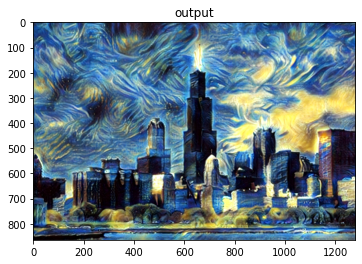

Current resolution: 512:  99%|█████████▊| 493/500 [13:11<00:11,  1.61s/it]


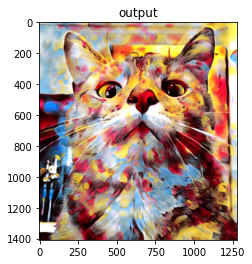

In [50]:
# 生成迭代次数和窗口大小等参数
def iters_and_sizes(size, iters, passes):
    iters_per_pass = np.arange(2 * passes, passes, -1)
    iters_per_pass = iters_per_pass / np.sum(iters_per_pass) * iters
    sizes = np.linspace(256, size, passes)
    # 将size四舍五入转化成32的倍数，确保池化后size依然是整数
    sizes = [int(size + 32 - 1) & -32 for size in sizes]
    proportion_per_layer = np.array([64, 128, 256, 512, 512]) + 64
    proportion_per_layer = proportion_per_layer / np.sum(proportion_per_layer)
    iters = (iters_per_pass[:, None] * proportion_per_layer[None, :]).astype(np.int32)
    return iters, sizes

# 风格迁移主函数
def style_transfer(
        style,
        content,
        size=512,
        content_strength=0.1,
        passes=5,
        iters=500
):
    iter, sizes = iters_and_sizes(size, iters, passes)
    bgsize = sizes[0]
    # 加载style和content数据
    style = load_image(style, bgsize)
    content = load_image(content, bgsize)
    # 初始化output图片数据
    output = torch.rand(content.shape, device=device)
    # 为style和content层编码，使之适应于VGG模型输入
    style_layers, style_eigvs, content_layers = encode_inputs(style, content)
    # 利用tqdm库生成进度条
    pbar = tqdm(total=iters, smoothing=0, position=0, leave=True)
    for i in range(passes):
        pbar.set_description(f"Current resolution: {sizes[i]}")
        for l in range(5, 0, -1):
            # 编码部分网络
            encoder=Encoder(l).to(device)
            output_layer = torch.matmul(encoder(output), style_eigvs[l])

            for _ in range(iter[i, l - 1]):
                output_layer = reoptimal(output_layer, style_layers[l])
                # 进行content图片编码匹配
                if l >= 3:
                    weight = content_strength / 2 ** (5 - l)
                    # 利用content_strength来调节输出层中style和content层所占比重
                    output_layer += weight * (content_layers[l] - output_layer)
                pbar.update(1)

            # 对主成分分析进行反向操作，得到输出层
            output_layer = torch.matmul(output_layer, style_eigvs[l].T)
            # 解码部分网络
            decoder = Decoder(l).to(device)
            # 对输出层进行解码，得到图片编码
            output = decoder(output_layer)
    pbar.close()
    return output


# 调用风格迁移主体函数，这里给出两个示例
# 第一个用例与课程所给用例对应，作为模型效果的展示
output1 = style_transfer(style1,content1)
result_dir1=save_image(output1,style1,content1,output_dir)
show_image(result_dir1)

# 第二个用例与论文Universal style transfer via feature transforms中所给的用例相同，
# 用于总结部分做对比分析
output2 = style_transfer(style2,content2)
result_dir2=save_image(output2,style2,content2,output_dir)
show_image(result_dir2)

## 总结与心得

&emsp;&emsp;本次任务中，考虑到**VGG19**卷积神经网络在物体识别方面有着较为突出的表现，我们选择了**VGG19**模型为baseline，在**VGG19**中加入了针对风格迁移的优化，使得图片的对比度和分辨率更高。同时，对于风格图片和内容图片，我们采用了主成分分析法与**VGG19**网络的提取图片内容的特点相结合，使得风格迁移的结果取得了更优的效果。

&emsp;&emsp;考虑到模型训练的时间成本问题，我们将预训练参数保存到本地，直接加载到**VGG19**模型上进行训练，使得我们的重心能够更多地放在针对风格迁移的模型优化方面。

&emsp;&emsp;在参数的调整与设置方面，经过多次实验后，我们发现content_strength参数设置成0.1时，content与style之间融合得最为和谐，风格迁移更加自然。

&emsp;&emsp;这里为了突出我们模型的优点，在style和content为相同图片的情况下，Li等于2017年提出的VGG auto-encoder framework模型的训练成果如下：

![](pictures/Li_result.jpg)

&emsp;&emsp;与上图我们的模型训练出的结果对比后，可以很明显地发现，两者的模型都将style和content完美地融合在了一起，实现了风格迁移，但是我们的模型训练出的结果对于content的特征结构突出的更加明显，减少了背景对于content特征的覆盖。